In [1]:
import matplotlib.pyplot as plt
import numpy as np
!pip install xgboost
from xgboost import XGBRegressor
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
!pip install tensorflow
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

file_path = 'C:\\Users\\mryol\\Downloads\\train.csv'
store_sales = pd.read_csv(file_path)

In [2]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [3]:
#Dropping store and item columns
store_sales = store_sales.drop(['store', 'item'], axis=1)
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [4]:
#Converting date as object datatype to a datetime datatype
store_sales['date'] = pd.to_datetime(store_sales['date'])
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [5]:
#Convert date to month periods, then sum number of items in each month
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [6]:
#Convert resulting date to timestamp datatype
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Text(0.5, 1.0, 'Monthly Customer Sales')

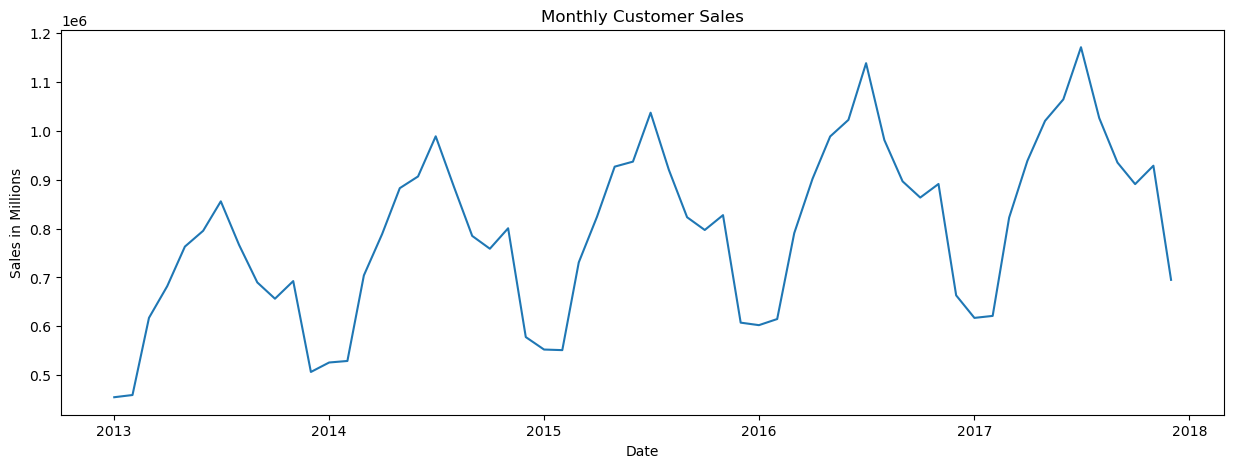

In [7]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales in Millions")
plt.title("Monthly Customer Sales")

In [8]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna(subset=['sales_diff'])
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


Text(0.5, 1.0, 'Monthly Customer Sales Difference')

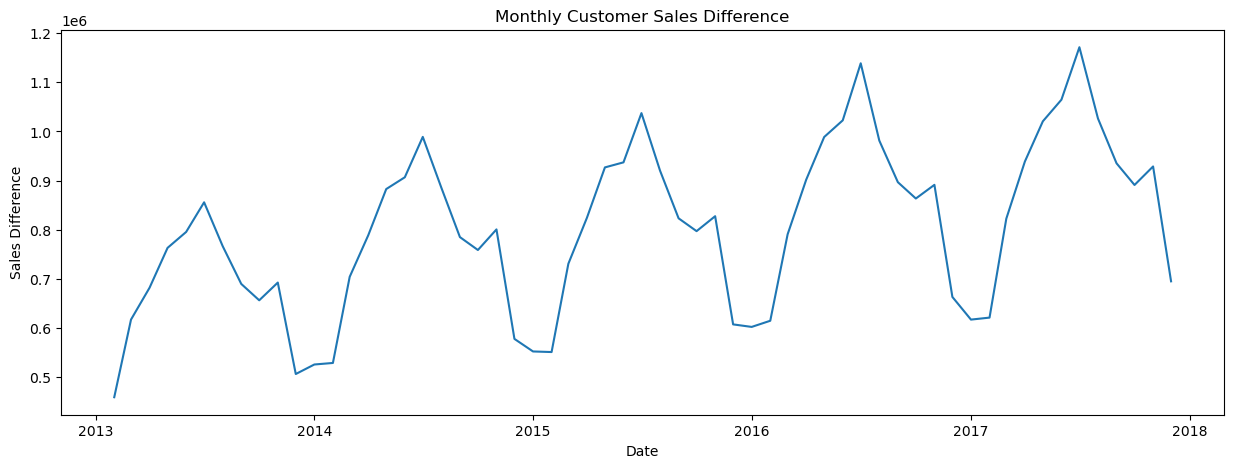

In [9]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales Difference")
plt.title("Monthly Customer Sales Difference")

In [10]:
#Preparing supervised data
#Dropping off sales and date
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

In [11]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [12]:
#Splitting data into training and testing sets
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [14]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", X_test.shape)

X_train Shape:  (35, 12)
y_train Shape:  (35,)
X_test Shape:  (12, 12)
y_test Shape:  (12, 12)


In [15]:
#Make prediction dataframe to merge with sale prices of all trained algos
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [16]:
actual_sales = monthly_sales['sales'][-13:].to_list()
print(actual_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [17]:
#Creating linear regression model and predicted output
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predict = lr_model.predict(X_test)

In [18]:
lr_predict = lr_predict.reshape(-1,1)
#This is a set matrix containing the input features of the test data and predicted output
lr_predict_test_set = np.concatenate([lr_predict, X_test], axis=1)
lr_predict_test_set = scaler.inverse_transform(lr_predict_test_set)

In [19]:
result_list = []
for index in range(0, len(lr_predict_test_set)):
    result_list.append(lr_predict_test_set[index][0] + actual_sales[index])
lr_predict_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_predict_series, left_index = True, right_index=True)

In [29]:
lr_mean_squared_error = mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_mean_absolute_error = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
root_mse = np.sqrt(lr_mean_squared_error)

print("Linear Regression MSE:", lr_mean_squared_error)
print("Linear Regression MAE:", lr_mean_absolute_error)
print("Linear Regression r2:", lr_r2)
print("Linear Regression Root MSE:", root_mse)

Linear Regression MSE: 263129677.8018874
Linear Regression MAE: 12433.184266490736
Linear Regression r2: 0.9906152516380969
Linear Regression Root MSE: 16221.272385416854


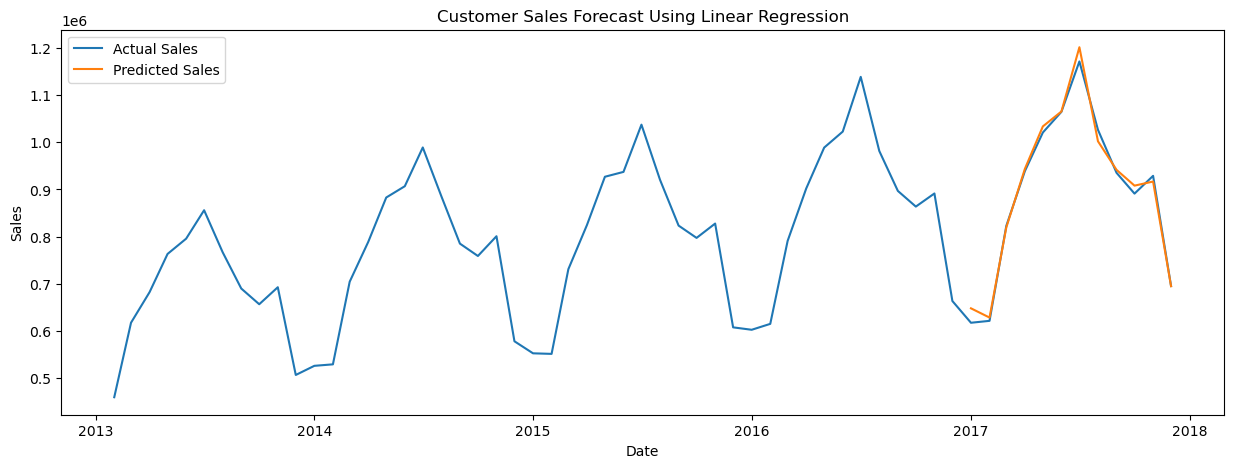

In [26]:
#Visualization of prediction against actual sales
plt.figure(figsize=(15,5))
#Actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
#Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer Sales Forecast Using Linear Regression")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])

In [30]:
correlation_coefficient = np.corrcoef(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
correlation_coefficient

array([[1.        , 0.99594063],
       [0.99594063, 1.        ]])

In [ ]:
#The end :) - James